Here I have one of the earliest versions of my code, but running on the GPU.

In [1]:
#PREPARE FOR BERT
!pip install transformers
!pip install datasets
!pip install fsspec==2024.10.0
!pip install --upgrade gcsfs

!pip show fsspec gcsfs datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
 

In [2]:
!pip install tensorflow==2.17.1


In [3]:
# Based on Kaggle code, importing libraries that may come in handy later on
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from sklearn.model_selection import train_test_split
# from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Embedding, Dropout, Bidirectional, LSTM
# from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.client import device_lib
# from tensorflow.keras.optimizers import AdamW as AdamW
print(device_lib.list_local_devices())
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertTokenizer
from transformers import TrainingArguments, Trainer
import tensorflow as tf
import os
os.environ["WANDB_DISABLED"] = "true"


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13823018364728557189
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17662703385652394172
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [4]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/AI UCM/IMDB Dataset.csv (1).zip')

# Convert sentiment to binary values
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

In [5]:
# Loading pre-trained tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Preprocessing text function
def preprocess_data(texts, labels, max_length=128):
    inputs = tokenizer(
        list(texts),
        max_length=max_length,
        padding=True,
        truncation=True,
        return_tensors="np"  # NumPy format
    )
    return {"input_ids": inputs["input_ids"], "attention_mask": inputs["attention_mask"]}, labels

# Preprocessing training and test data
train_inputs, train_labels = preprocess_data(X_train, y_train)
test_inputs, test_labels = preprocess_data(X_test, y_test)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
import torch
torch.cuda.is_available()


True

In [7]:
# Load the BERT model pre-trained for sequence classification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2  # Binary classification
)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

# Define loss and metric
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric_fn = tf.keras.metrics.SparseCategoricalAccuracy()

# Prepare the datasets
# Simplify the Trainer setup

from datasets import Dataset
from sklearn.metrics import accuracy_score

# Preprocess the data (already done earlier)
train_dataset = Dataset.from_dict({
    "input_ids": train_inputs["input_ids"],
    "attention_mask": train_inputs["attention_mask"],
    "labels": train_labels
})
test_dataset = Dataset.from_dict({
    "input_ids": test_inputs["input_ids"],
    "attention_mask": test_inputs["attention_mask"],
    "labels": test_labels
})

# Trainer setup
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=8,  # Decrease batch size
    per_device_eval_batch_size=8,
    num_train_epochs=3,  # Reduce epochs for quicker feedback
    report_to="none"
)

# Define a proper compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Start training (this will take time, but it's more manageable now)
trainer.train()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-7-93d28fcf1f35>:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  

Epoch,Training Loss,Validation Loss,Accuracy
1,0.353100,0.368032,0.876300
2,0.254100,0.379882,0.891400
3,0.117800,0.541141,0.892800


TrainOutput(global_step=15000, training_loss=0.25475770416259763, metrics={'train_runtime': 3351.8094, 'train_samples_per_second': 35.802, 'train_steps_per_second': 4.475, 'total_flos': 7893331660800000.0, 'train_loss': 0.25475770416259763, 'epoch': 3.0})

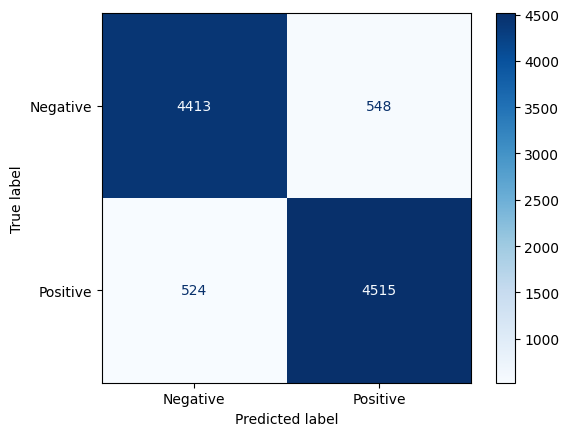

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions from the Trainer
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)
true_labels = predictions.label_ids

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")


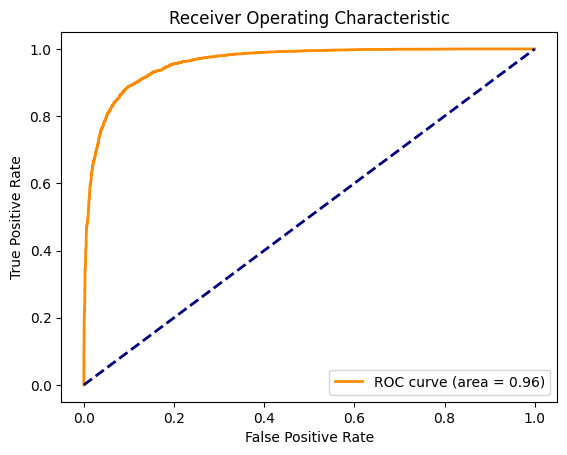

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get probabilities for the positive class
probs = predictions.predictions[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()


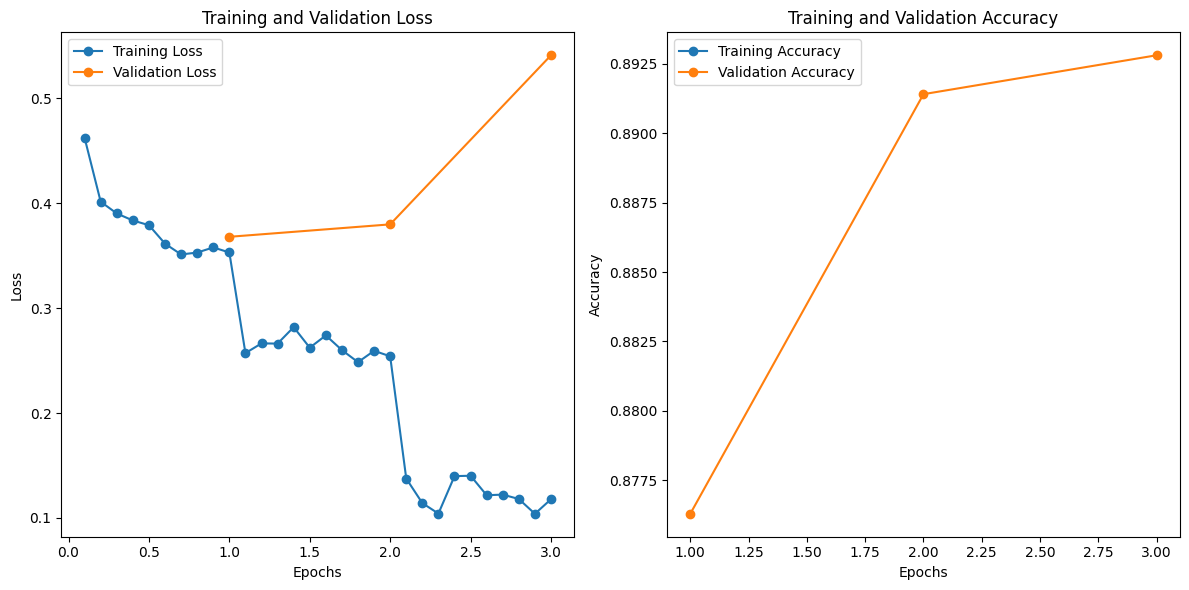

In [13]:
# Access the training logs from the Trainer
history = trainer.state.log_history

# Separate the logs for training and evaluation
train_logs = [log for log in history if "loss" in log and "epoch" in log]
eval_logs = [log for log in history if "eval_loss" in log]

# Extract epochs, training loss, and validation loss
epochs = [log["epoch"] for log in train_logs]
train_loss = [log["loss"] for log in train_logs]
eval_loss = [log["eval_loss"] for log in eval_logs]
train_accuracy = [log.get("accuracy", None) for log in train_logs]
eval_accuracy = [log.get("eval_accuracy", None) for log in eval_logs]

# Align epochs for evaluation metrics
eval_epochs = [i + 1 for i in range(len(eval_loss))]  # Create epochs for eval metrics

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Training Loss", marker="o")
plt.plot(eval_epochs, eval_loss, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label="Training Accuracy", marker="o")
plt.plot(eval_epochs, eval_accuracy, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
